# Autoencoders for MNIST reconstruction
## Short experiment to weight the importance of certain elements in the architecture and loss

Sponsored by neuromatch academy lessons on [autoencoders](https://compneuro.neuromatch.io/tutorials/Bonus_Autoencoders/student/Bonus_Tutorial1.html)

In [ ]:
%load_ext autoreload
%autoreload 2

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
from sklearn.datasets import fetch_openml

In [10]:
# Helper functions
def flatten_images(images):
    """
    Flattens images into a 1D arrays.

    Parameters:
    -----------
    images: torch.Tensor
        3D array of images.

    Returns:
    --------
    images: torch.Tensor
        2D array of flattened images.
    """
    image_shape = images.shape[1:]
    input_size = np.prod(image_shape)
    return images.reshape([-1, input_size])

def eval_mse(y_pred, y_true):
  """
  Evaluates Mean Square Error (MSE) between y_pred and y_true

  Args:
    y_pred (torch.Tensor)
        prediction samples

    v (numpy array of floats)
        ground truth samples

  Returns:
    MSE(y_pred, y_true)
  """

  with torch.no_grad():
      criterion = torch.nn.MSELoss()
      loss = criterion(y_pred, y_true)

  return float(loss)

def eval_bce(y_pred, y_true):
  """
  Evaluates Binary Cross-Entropy (BCE) between y_pred and y_true

  Args:
    y_pred (torch.Tensor)
        prediction samples

    v (numpy array of floats)
        ground truth samples

  Returns:
    BCE(y_pred, y_true)
  """

  with torch.no_grad():
      criterion = torch.nn.BCELoss()
      loss = criterion(y_pred, y_true)

  return float(loss)

def train_small_dataset(net, input_train, input_test, device='cpu', criterion='bce',
           n_epochs=10, batch_size=32, verbose=False, is_plot=True):
  """
  Trains network with stochastic gradient descent with Adam
  optimizer and loss criterion. Train samples are shuffled, and loss is
  displayed at the end of each opoch for both MSE and BCE. Plots training loss
  at each minibatch (maximum of 500 randomly selected values).

  Args:
    net (torch network)
        ANN object (nn.Module)

    input_train (torch.Tensor)
        vectorized input images from train set

    input_test (torch.Tensor)
        vectorized input images from test set

    criterion (string)
        train loss: 'bce' or 'mse'

    n_epochs (boolean)
        number of full iterations of training data

    batch_size (integer)
        number of element in mini-batches

    verbose (boolean)
        whether to print final loss

  Returns:
    Nothing.
  """

  # Create data loader
  train_data_loader = torch.utils.data.DataLoader(
    input_train, batch_size=batch_size, shuffle=True
    )
  net.to(device)

  # Initialize loss function
  if criterion == 'mse':
    loss_fn = torch.nn.MSELoss()
  elif criterion == 'bce':
    loss_fn = torch.nn.BCELoss()
  else:
    print('Please specify either "mse" or "bce" for loss criterion')

  # Initialize SGD optimizer
  optimizer = torch.optim.Adam(net.parameters())

  # Placeholder for loss
  track_loss = []

  print('Epoch', '\t', 'Loss train', '\t', 'Loss test')
  for i in range(n_epochs):

    for batch in tqdm.tqdm(train_data_loader, ncols=50):
        
      output_train = net(batch.to(device))
      loss = loss_fn(output_train, batch).to(device)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Keep track of loss at each epoch
      detached_loss = loss.detach().cpu().numpy()
      track_loss += [float(detached_loss)]

    num_epoch = f'{i + 1} / {n_epochs}'
    with torch.no_grad():
      # We evaluate loss on the entire dataset because it's small
      # If the dataset is large, we would evaluate on a subset that fits in memory
      output_train = net(input_train)
      loss_train = loss_fn(output_train, input_train)
      num_epoch += f'\t {loss_train:.4f}'

      output_test = net(input_test)
      loss_test = loss_fn(output_test, input_test)
      num_epoch += f'\t\t {loss_test:.4f}'

    print(num_epoch)

  if verbose:
    # Print final loss
    loss_mse = f'\nMSE\t {eval_mse(output_train, input_train):0.4f}'
    loss_mse += f'\t\t {eval_mse(output_test, input_test):0.4f}'
    print(loss_mse)

    loss_bce = f'BCE\t {eval_bce(output_train, input_train):0.4f}'
    loss_bce += f'\t\t {eval_bce(output_test, input_test):0.4f}'
    print(loss_bce)

  # Plot loss
  if is_plot:
    step = int(np.ceil(len(track_loss) / 500))
    x_range = np.arange(0, len(track_loss), step)
    plt.figure()
    plt.plot(x_range, track_loss[::step], 'C0')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Training running loss')
    plt.xlim([0, None])
    plt.ylim([0, None])
    plt.show()

def plot_row(images, show_n=10, image_shape=None):
  """
  Plots rows of images from list of iterables (iterables: list, numpy array
  or torch.Tensor). Also accepts single iterable.
  Randomly selects images in each list element if item count > show_n.

  Args:
    images (iterable or list of iterables)
        single iterable with images, or list of iterables

    show_n (integer)
        maximum number of images per row

    image_shape (tuple or list)
        original shape of image if vectorized form

  Returns:
    Nothing.
  """

  if not isinstance(images, (list, tuple)):
    images = [images]

  for items_idx, items in enumerate(images):

    items = np.array(items)
    if items.ndim == 1:
      items = np.expand_dims(items, axis=0)

    if len(items) > show_n:
      selected = np.random.choice(len(items), show_n, replace=False)
      items = items[selected]

    if image_shape is not None:
      items = items.reshape([-1] + list(image_shape))

    plt.figure(figsize=(len(items) * 1.5, 4))
    for image_idx, image in enumerate(items):

      plt.subplot(1, len(items), image_idx + 1)
      plt.imshow(image, cmap='gray', aspect='auto', vmin=image.min(), vmax=image.max())
      plt.axis('off')

      plt.tight_layout()


## Load and prepare the data

In [ ]:
## Get MNIST data
def downloadMNIST():
  """
  Download MNIST dataset and transform it to torch.Tensor

  Args:
    None

  Returns:
    x_train : training images (torch.Tensor) (60000, 28, 28)
    x_test  : test images (torch.Tensor) (10000, 28, 28)
    y_train : training labels (torch.Tensor) (60000, )
    y_train : test labels (torch.Tensor) (10000, )
  """
  X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
  # Trunk the data
  n_train = 60000
  n_test = 10000

  train_idx = np.arange(0, n_train)
  test_idx = np.arange(n_train, n_train + n_test)

  x_train, y_train = X[train_idx], y[train_idx]
  x_test, y_test = X[test_idx], y[test_idx]

  # Transform np.ndarrays to torch.Tensor
  x_train = torch.from_numpy(np.reshape(x_train,
                                        (len(x_train),
                                         28, 28)).astype(np.float32))
  x_test = torch.from_numpy(np.reshape(x_test,
                                       (len(x_test),
                                        28, 28)).astype(np.float32))

  y_train = torch.from_numpy(y_train.astype(int))
  y_test = torch.from_numpy(y_test.astype(int))

  return (x_train, y_train, x_test, y_test)

x_train, y_train, x_test, y_test = downloadMNIST()
mnist_train = x_train
mnist_test = x_test

# Normalize the data between 0 and 1
mnist_data_train = mnist_train / mnist_train.max()
mnist_data_test = mnist_test / mnist_test.max()

In [12]:
# Flatten the data
flat_mnist_data_train = flatten_images(mnist_data_train)
flat_mnist_data_test = flatten_images(mnist_data_test)
print(f'flat mnist train data shape: {flat_mnist_data_train.shape}', f'flat mnist test data shape: {flat_mnist_data_test.shape}')

flat mnist train data shape: torch.Size([60000, 784]) flat mnist test data shape: torch.Size([10000, 784])


## Model search


### Without training

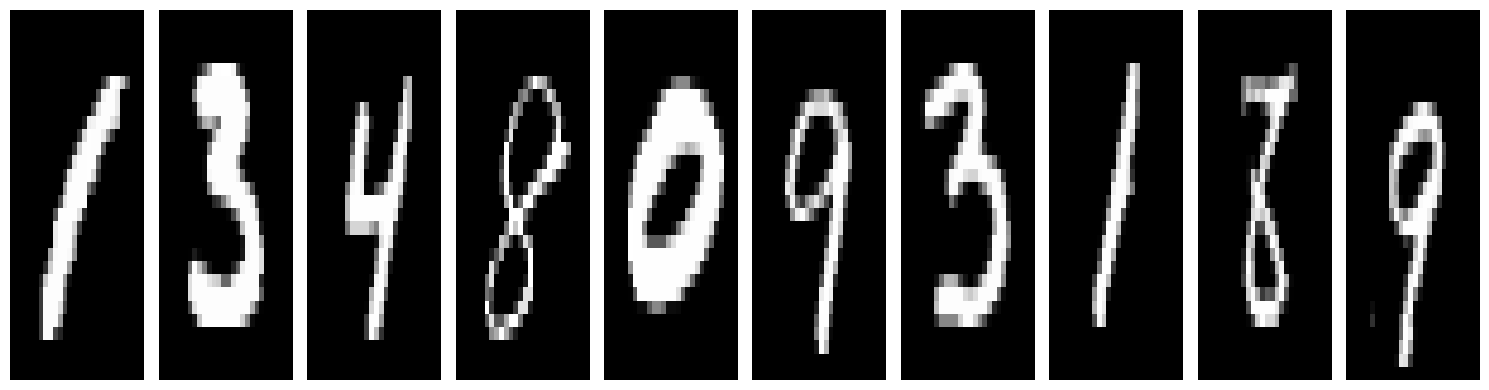

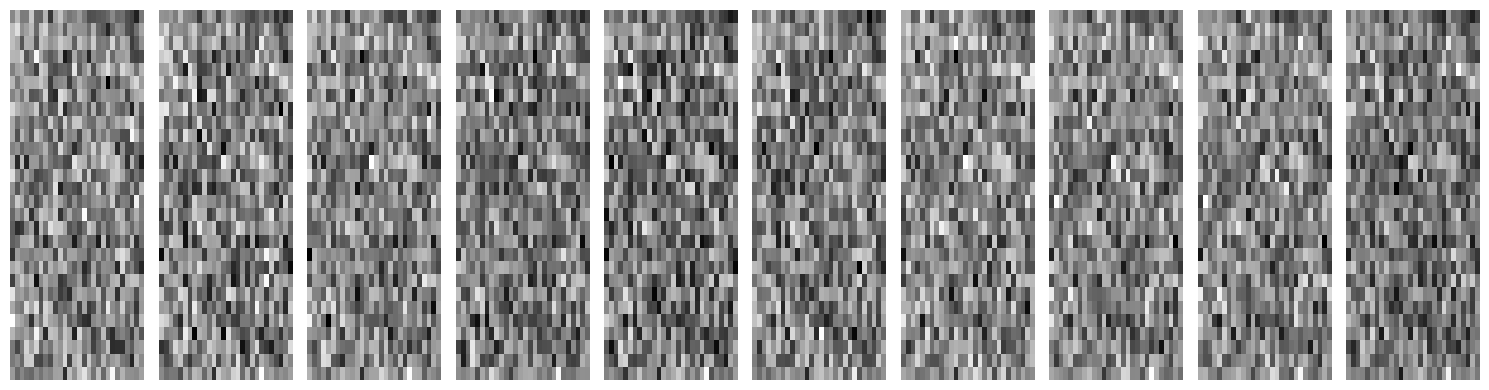

In [13]:
encoding_size = 32
def init_linear_autoencoder(input_size, encoding_size):
    model = torch.nn.Sequential(
        torch.nn.Linear(input_size, encoding_size),
        torch.nn.PReLU(),
        torch.nn.Linear(encoding_size, input_size),
        torch.nn.Sigmoid()
        )
    return model


### MNIST
model = init_linear_autoencoder(flat_mnist_data_train.shape[1], encoding_size)
with torch.no_grad():
  output_test = model(flat_mnist_data_test)

plot_row([flat_mnist_data_test.float(), output_test], image_shape=(28, 28))

You can see that an untrained model (a model that has random weights) outputs a random image. What happens if we train the model?

### Train the simplest linear autoencoder with MSE loss

Epoch 	 Loss train 	 Loss test


100%|██████████| 938/938 [00:03<00:00, 246.64it/s]


1 / 10	 0.0234		 0.0230


100%|██████████| 938/938 [00:04<00:00, 229.41it/s]


2 / 10	 0.0147		 0.0143


100%|██████████| 938/938 [00:04<00:00, 230.74it/s]


3 / 10	 0.0116		 0.0112


100%|██████████| 938/938 [00:04<00:00, 230.48it/s]


4 / 10	 0.0107		 0.0103


100%|██████████| 938/938 [00:04<00:00, 224.92it/s]


5 / 10	 0.0103		 0.0100


100%|██████████| 938/938 [00:08<00:00, 113.57it/s]


6 / 10	 0.0101		 0.0098


100%|██████████| 938/938 [00:06<00:00, 140.37it/s]


7 / 10	 0.0100		 0.0097


100%|██████████| 938/938 [00:05<00:00, 161.73it/s]


8 / 10	 0.0099		 0.0096


100%|██████████| 938/938 [00:09<00:00, 102.15it/s]


9 / 10	 0.0098		 0.0096


100%|██████████| 938/938 [00:04<00:00, 199.24it/s]


10 / 10	 0.0098		 0.0095

MSE	 0.0098		 0.0095
BCE	 0.0942		 0.0930


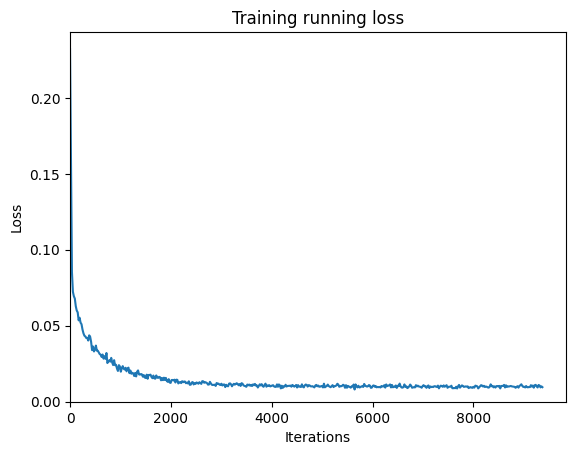

In [14]:
### MNIST
model_mnist = init_linear_autoencoder(flat_mnist_data_train.shape[1], encoding_size)

n_epochs = 10
batch_size = 64

train_small_dataset(model_mnist, flat_mnist_data_train, flat_mnist_data_test, criterion='mse',
       n_epochs=n_epochs, batch_size=batch_size, verbose=True)

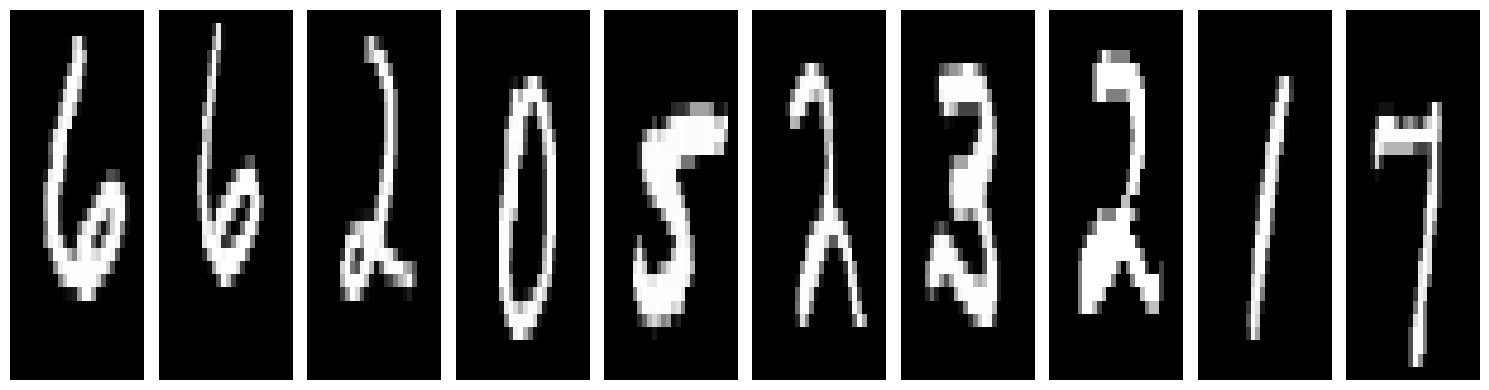

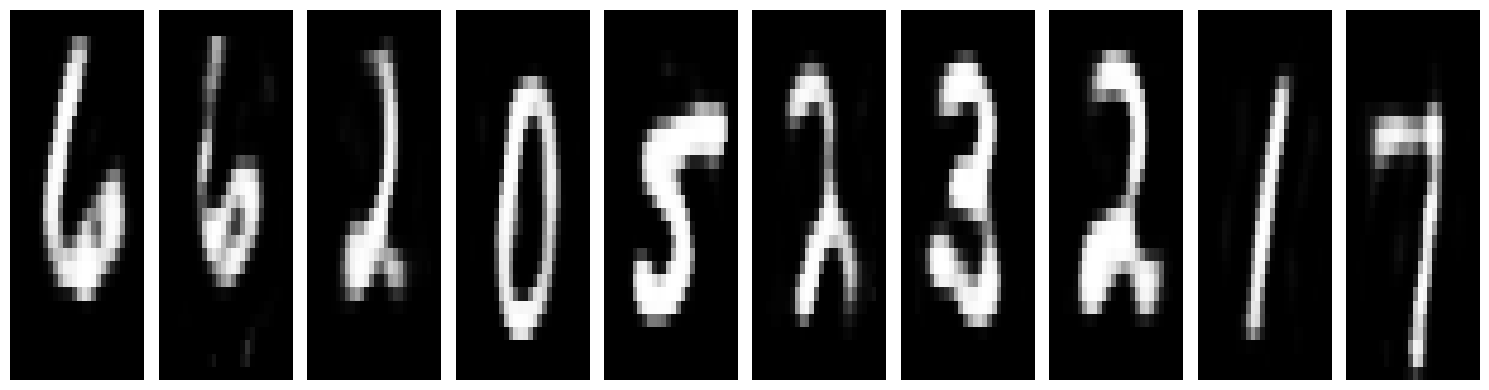

In [15]:
test_selected_idx_mnist = np.random.choice(len(flat_mnist_data_test), 10, replace=False)
with torch.no_grad():
  output_test = model_mnist(flat_mnist_data_test)

plot_row([flat_mnist_data_test[test_selected_idx_mnist], output_test[test_selected_idx_mnist]],
         image_shape=(28, 28))

The smallest autoencoder already performs very decent reconstruction. The loss is very low and the images are already recognizable.
However, sometimes the images are not as sharp as the original ones. I hope to address that by changing MSE loss by BCE loss to penalize
the model for ambiguous pixels.

### Train the simplest linear autoencoder with MSE loss

Epoch 	 Loss train 	 Loss test


100%|██████████| 938/938 [00:07<00:00, 127.02it/s]


1 / 10	 0.1369		 0.1359


100%|██████████| 938/938 [00:06<00:00, 154.92it/s]


2 / 10	 0.1059		 0.1046


100%|██████████| 938/938 [00:05<00:00, 174.68it/s]


3 / 10	 0.0962		 0.0949


100%|██████████| 938/938 [00:05<00:00, 166.67it/s]


4 / 10	 0.0943		 0.0931


100%|██████████| 938/938 [00:05<00:00, 157.93it/s]


5 / 10	 0.0935		 0.0923


100%|██████████| 938/938 [00:06<00:00, 152.20it/s]


6 / 10	 0.0931		 0.0919


100%|██████████| 938/938 [00:06<00:00, 155.12it/s]


7 / 10	 0.0929		 0.0917


100%|██████████| 938/938 [00:06<00:00, 138.52it/s]


8 / 10	 0.0928		 0.0916


100%|██████████| 938/938 [00:07<00:00, 124.85it/s]


9 / 10	 0.0927		 0.0916


100%|██████████| 938/938 [00:07<00:00, 132.64it/s]


10 / 10	 0.0926		 0.0915

MSE	 0.0099		 0.0096
BCE	 0.0926		 0.0915


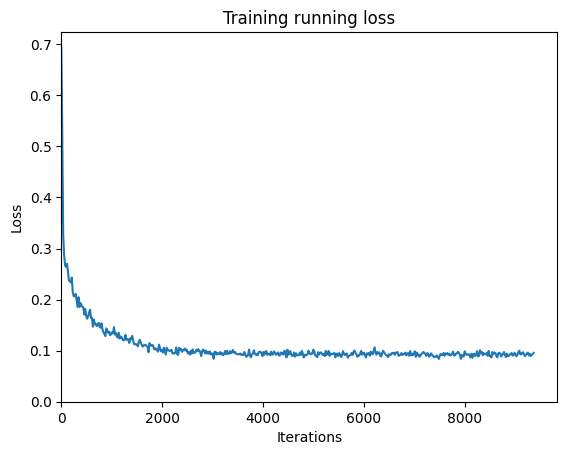

In [16]:
model_mnist = init_linear_autoencoder(flat_mnist_data_train.shape[1], encoding_size)

n_epochs = 10
batch_size = 64

train_small_dataset(model_mnist, flat_mnist_data_train, flat_mnist_data_test, criterion='bce',
       n_epochs=n_epochs, batch_size=batch_size, verbose=True)

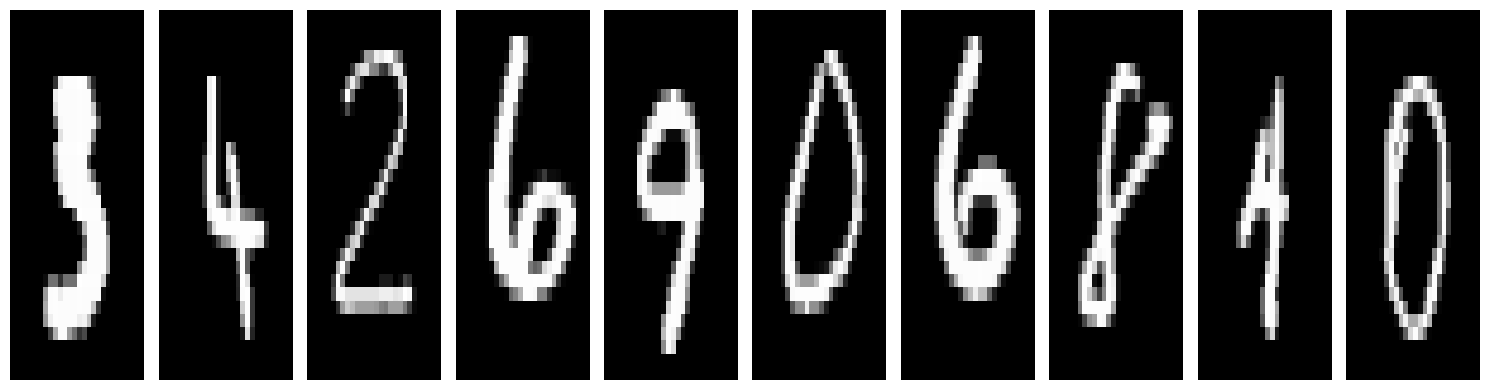

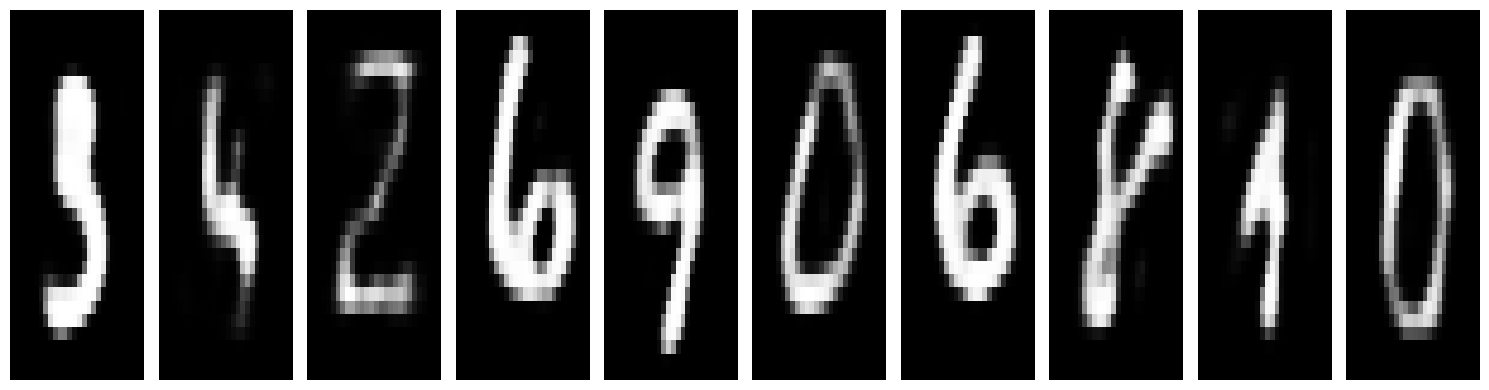

In [17]:
test_selected_idx_mnist = np.random.choice(len(flat_mnist_data_test), 10, replace=False)

with torch.no_grad():
  output_test = model_mnist(flat_mnist_data_test)

plot_row([flat_mnist_data_test[test_selected_idx_mnist], output_test[test_selected_idx_mnist]],
         image_shape=(28, 28))

BCE loss gave us slightly better results but only ever so slightly. The images are still not as sharp as the original ones. I hope to address that by adding more layers to the model.
I keep the BCE loss as it gave us slightly better results.

### Train large autoencoder (5 layers encoder/5 layers decoder) with BCE loss 

In [18]:
def init_large_linear_autoencoder(input_size, encoding_size):
    return torch.nn.Sequential(
        torch.nn.Linear(input_size, 2048),
        torch.nn.PReLU(),
        torch.nn.Linear(2048, 1024),
        torch.nn.PReLU(),
        torch.nn.Linear(1024, 512),
        torch.nn.PReLU(),
        torch.nn.Linear(512, 128),
        torch.nn.PReLU(),
        torch.nn.Linear(128, encoding_size),
        torch.nn.Linear(encoding_size, 128),
        torch.nn.PReLU(),
        torch.nn.Linear(128, 512),
        torch.nn.PReLU(),
        torch.nn.Linear(512, 2024),
        torch.nn.PReLU(),
        torch.nn.Linear(2024, input_size),
        torch.nn.Sigmoid()
    )

Epoch 	 Loss train 	 Loss test


100%|███████████| 938/938 [01:51<00:00,  8.41it/s]


1 / 10	 0.1083		 0.1074


100%|███████████| 938/938 [01:44<00:00,  9.01it/s]


2 / 10	 0.0925		 0.0927


100%|███████████| 938/938 [01:29<00:00, 10.48it/s]


3 / 10	 0.0873		 0.0881


100%|███████████| 938/938 [01:21<00:00, 11.53it/s]


4 / 10	 0.0843		 0.0856


100%|███████████| 938/938 [01:20<00:00, 11.61it/s]


5 / 10	 0.0822		 0.0837


100%|███████████| 938/938 [01:21<00:00, 11.56it/s]


6 / 10	 0.0804		 0.0824


100%|███████████| 938/938 [01:20<00:00, 11.71it/s]


7 / 10	 0.0804		 0.0825


100%|███████████| 938/938 [01:20<00:00, 11.61it/s]


8 / 10	 0.0784		 0.0809


100%|███████████| 938/938 [01:19<00:00, 11.77it/s]


9 / 10	 0.0776		 0.0804


100%|███████████| 938/938 [01:18<00:00, 11.99it/s]


10 / 10	 0.0777		 0.0807

MSE	 0.0054		 0.0065
BCE	 0.0777		 0.0807


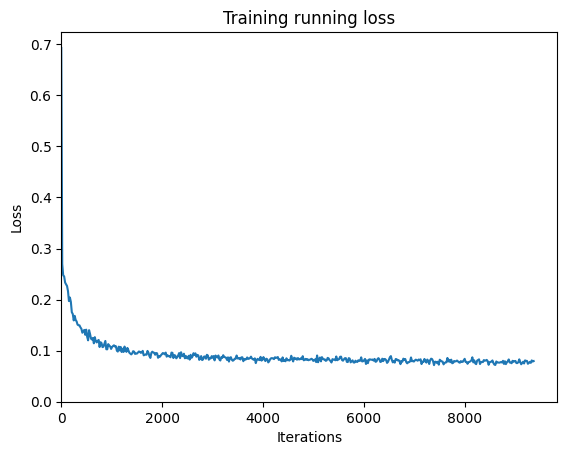

In [19]:
model_mnist = init_large_linear_autoencoder(flat_mnist_data_train.shape[1], encoding_size)

n_epochs = 10
batch_size = 64

train_small_dataset(model_mnist, flat_mnist_data_train, flat_mnist_data_test, criterion='bce',
       n_epochs=n_epochs, batch_size=batch_size, verbose=True)

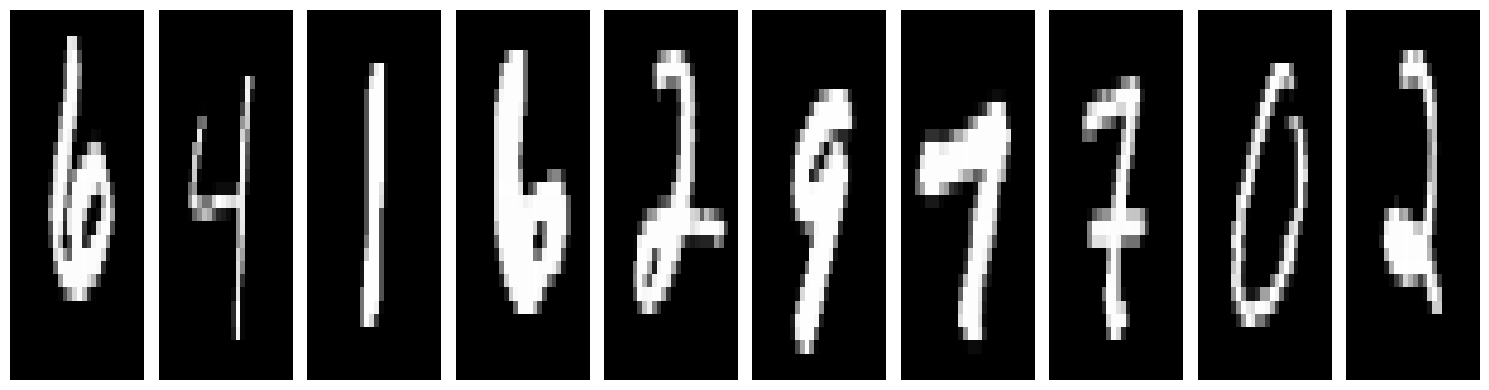

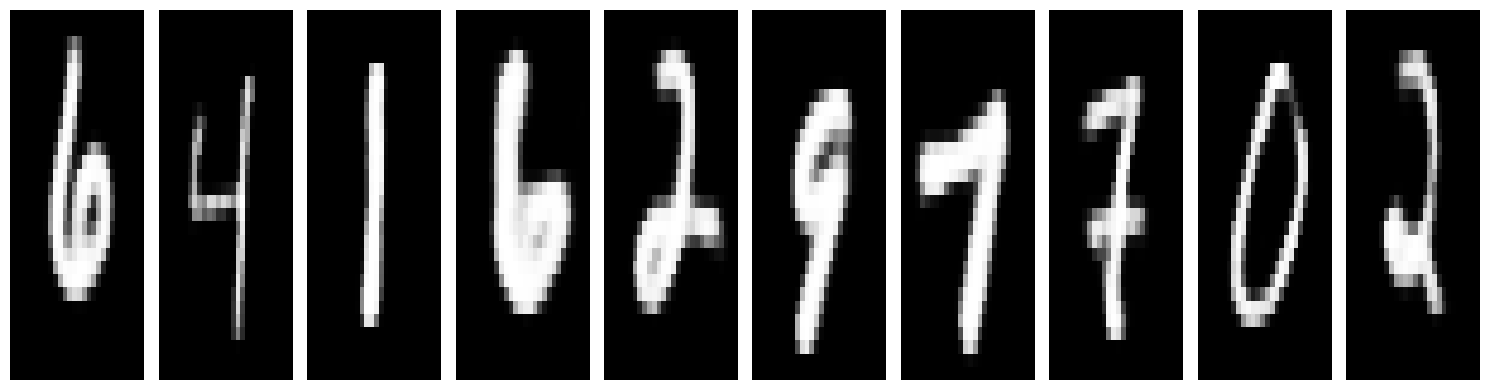

In [20]:
test_selected_idx_mnist = np.random.choice(len(flat_mnist_data_test), 10, replace=False)

with torch.no_grad():
  output_test = model_mnist(flat_mnist_data_test)

plot_row([flat_mnist_data_test[test_selected_idx_mnist], output_test[test_selected_idx_mnist]],
         image_shape=(28, 28))

Large linear model significantly improves the performance. It does not get the holes in the digits well but overall it is a great improvement over the previous models.
This was achieved by increased model complexity, which means a huge increase in the number of parameters. It makes the model very heavy and slow to train.
Let's address by using convolutional layers.

### Train simple convolutional model

In [21]:
def init_conv_autoencoder(input_shape, encoding_size):
    last_size_1 = input_shape[1] - 2*(5-1)
    last_size_2 = input_shape[2] - 2*(5-1)
    flat_after_conv = 16 * last_size_1 * last_size_2
    return torch.nn.Sequential(
        torch.nn.Conv2d(1, 16, kernel_size=5),
        torch.nn.LeakyReLU(),
        torch.nn.Conv2d(16, 16, kernel_size=5),
        torch.nn.LeakyReLU(),
        torch.nn.Flatten(),
        torch.nn.Linear(flat_after_conv, encoding_size),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(encoding_size, flat_after_conv),
        torch.nn.Unflatten(1, (16, last_size_1, last_size_2)),
        torch.nn.ConvTranspose2d(16, 16, kernel_size=5),
        torch.nn.LeakyReLU(),
        torch.nn.ConvTranspose2d(16, 1, kernel_size=5),
        torch.nn.Sigmoid()
    )

In [22]:
# Prepare data for convolutional autoencoder
mnist_data_train_conv = mnist_data_train.unsqueeze(1)
mnist_data_test_conv = mnist_data_test.unsqueeze(1)
print(f'mnist train data shape: {mnist_data_train_conv.shape}', f'mnist test data shape: {mnist_data_test_conv.shape}')

mnist train data shape: torch.Size([60000, 1, 28, 28]) mnist test data shape: torch.Size([10000, 1, 28, 28])


Epoch 	 Loss train 	 Loss test


100%|███████████| 938/938 [00:41<00:00, 22.81it/s]


1 / 10	 0.0921		 0.0908


100%|███████████| 938/938 [00:43<00:00, 21.59it/s]


2 / 10	 0.0859		 0.0849


100%|███████████| 938/938 [00:43<00:00, 21.48it/s]


3 / 10	 0.0825		 0.0818


100%|███████████| 938/938 [00:42<00:00, 22.24it/s]


4 / 10	 0.0807		 0.0800


100%|███████████| 938/938 [00:42<00:00, 22.13it/s]


5 / 10	 0.0783		 0.0778


100%|███████████| 938/938 [00:45<00:00, 20.42it/s]


6 / 10	 0.0772		 0.0767


100%|███████████| 938/938 [00:43<00:00, 21.61it/s]


7 / 10	 0.0765		 0.0761


100%|███████████| 938/938 [00:40<00:00, 23.03it/s]


8 / 10	 0.0757		 0.0754


100%|███████████| 938/938 [00:51<00:00, 18.27it/s]


9 / 10	 0.0749		 0.0746


100%|███████████| 938/938 [00:45<00:00, 20.71it/s]


10 / 10	 0.0748		 0.0746

MSE	 0.0046		 0.0046
BCE	 0.0748		 0.0746


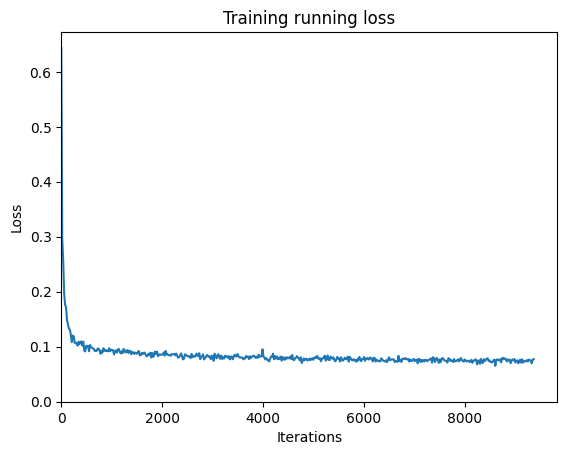

In [23]:
model_mnist = init_conv_autoencoder(mnist_data_train_conv.shape[1:], encoding_size)

n_epochs = 10
batch_size = 64

train_small_dataset(model_mnist, mnist_data_train_conv, mnist_data_test_conv, criterion='bce',
       n_epochs=n_epochs, batch_size=batch_size, verbose=True)

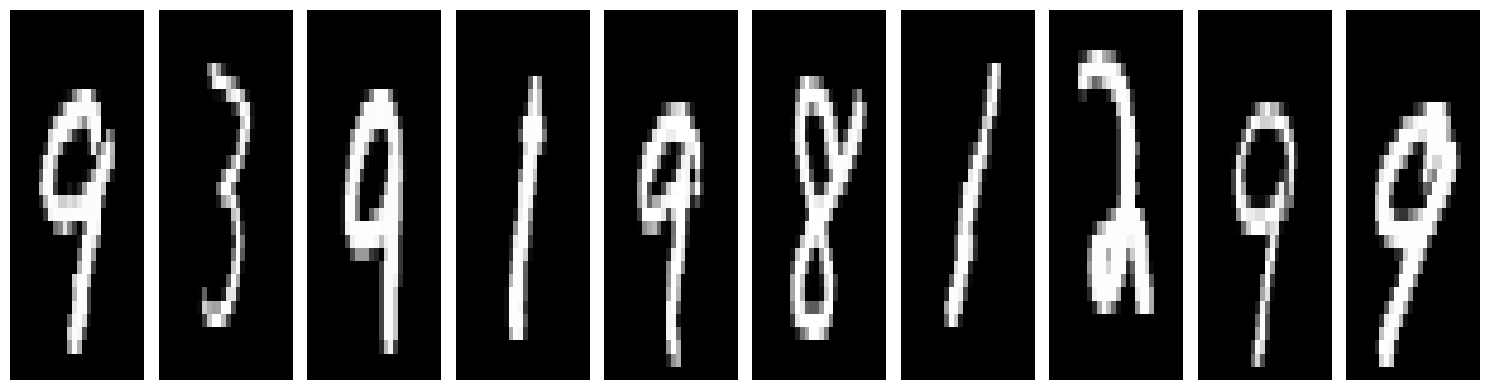

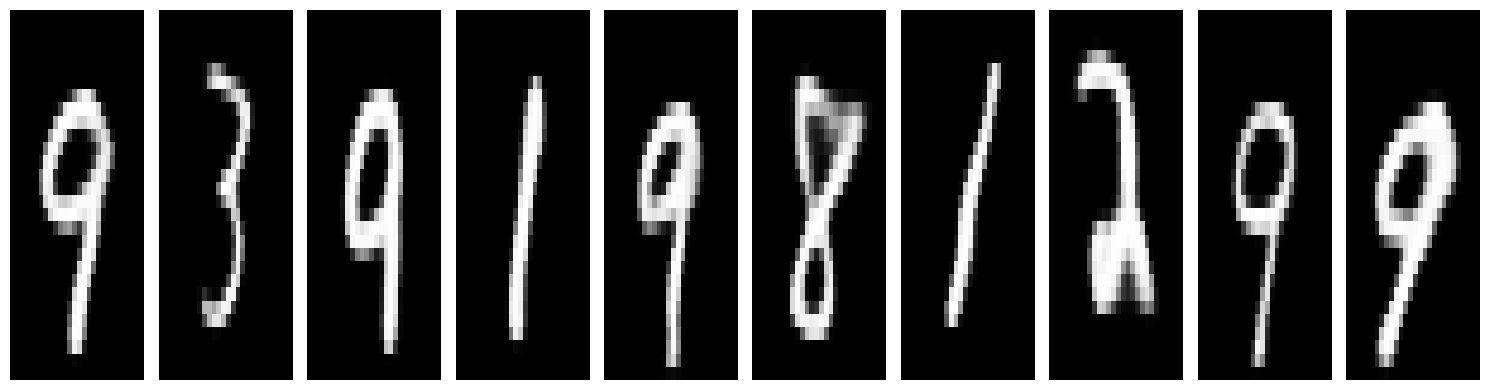

In [24]:
test_selected_idx_mnist = np.random.choice(len(mnist_data_test_conv), 10, replace=False)

with torch.no_grad():
  output_test = model_mnist(mnist_data_test_conv)

plot_row([mnist_data_test_conv[test_selected_idx_mnist], output_test[test_selected_idx_mnist]],
         image_shape=(28, 28))

We improved the reconstruction more. The model is lighter and faster to train. However, I am still not very happy with the model's weight. Let's add larger stride for the second convolutional layer to reduce the number of parameters.

### Implement stride on the second layer

In [25]:
def init_conv_autoencoder_with_strides(input_shape, encoding_size):
    last_size_1 = input_shape[1] - 2*(5-1)
    last_size_2 = int((input_shape[2] - 2*(5-1))/2)
    flat_after_conv = int(16 * last_size_1/2 * last_size_2)
    print(flat_after_conv)
    return torch.nn.Sequential(
        torch.nn.Conv2d(1, 16, kernel_size=5),
        torch.nn.PReLU(),
        torch.nn.Conv2d(16, 16, kernel_size=5, stride=2),
        torch.nn.PReLU(),
        torch.nn.Flatten(),
        torch.nn.Linear(flat_after_conv, encoding_size),
        torch.nn.PReLU(),
        torch.nn.Linear(encoding_size, flat_after_conv),
        torch.nn.Unflatten(-1, (16, int(last_size_1/2), last_size_2)),
        torch.nn.ConvTranspose2d(16, 16, kernel_size=5, stride=2, output_padding=1),
        torch.nn.PReLU(),
        torch.nn.ConvTranspose2d(16, 1, kernel_size=5),
        torch.nn.Sigmoid()
    )

1600
Epoch 	 Loss train 	 Loss test


100%|███████████| 938/938 [00:29<00:00, 32.03it/s]


1 / 10	 0.0889		 0.0878


100%|███████████| 938/938 [00:31<00:00, 30.26it/s]


2 / 10	 0.0828		 0.0818


100%|███████████| 938/938 [00:33<00:00, 27.86it/s]


3 / 10	 0.0799		 0.0791


100%|███████████| 938/938 [00:32<00:00, 29.26it/s]


4 / 10	 0.0780		 0.0772


100%|███████████| 938/938 [00:28<00:00, 32.68it/s]


5 / 10	 0.0767		 0.0760


100%|███████████| 938/938 [00:33<00:00, 27.79it/s]


6 / 10	 0.0758		 0.0752


100%|███████████| 938/938 [00:37<00:00, 25.27it/s]


7 / 10	 0.0754		 0.0748


100%|███████████| 938/938 [00:38<00:00, 24.50it/s]


8 / 10	 0.0743		 0.0738


100%|███████████| 938/938 [00:28<00:00, 32.97it/s]


9 / 10	 0.0739		 0.0734


100%|███████████| 938/938 [00:28<00:00, 33.12it/s]


10 / 10	 0.0736		 0.0731

MSE	 0.0041		 0.0040
BCE	 0.0736		 0.0731


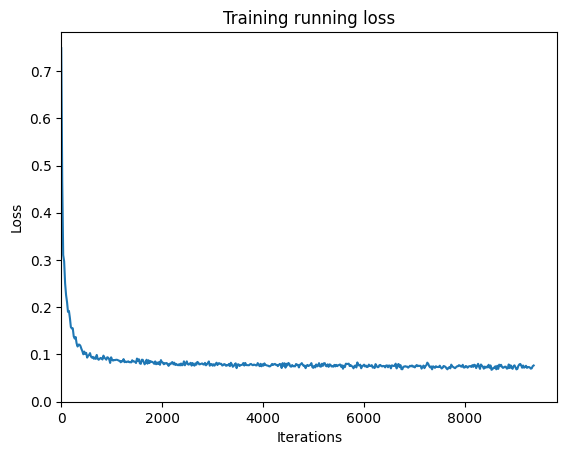

In [26]:
model_mnist = init_conv_autoencoder_with_strides(mnist_data_train_conv.shape[1:], encoding_size)

n_epochs = 10
batch_size = 64

train_small_dataset(model_mnist, mnist_data_train_conv, mnist_data_test_conv, criterion='bce',
       n_epochs=n_epochs, batch_size=batch_size, verbose=True)

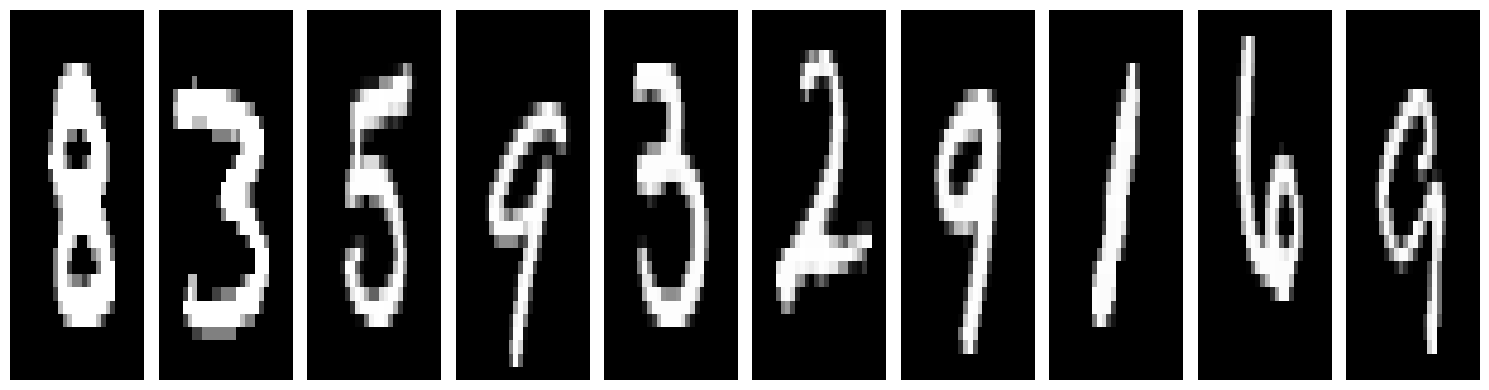

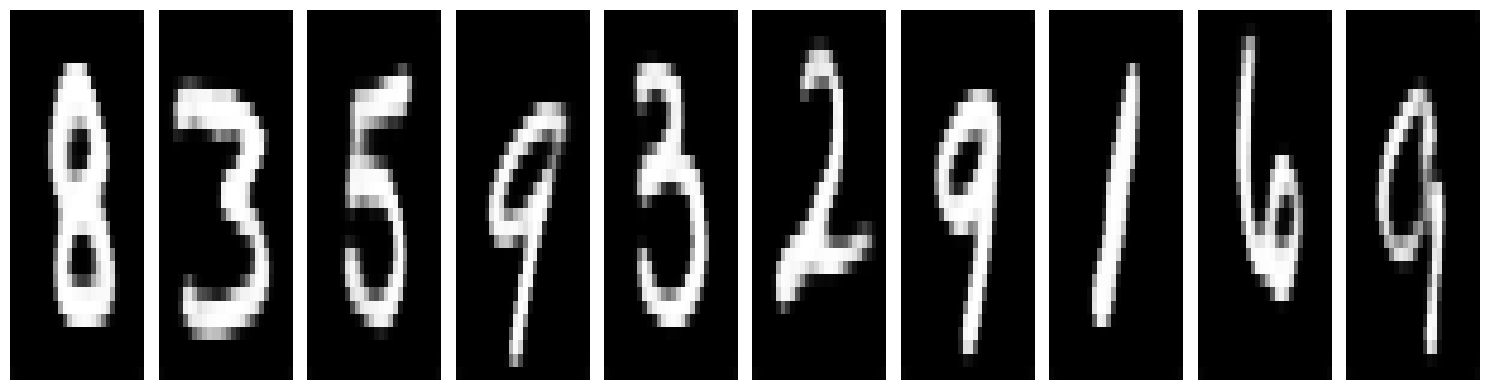

In [27]:
test_selected_idx_mnist = np.random.choice(len(mnist_data_test_conv), 10, replace=False)

with torch.no_grad():
  output_test = model_mnist(mnist_data_test_conv)

plot_row([mnist_data_test_conv[test_selected_idx_mnist], output_test[test_selected_idx_mnist]],
         image_shape=(28, 28))

I get sligthly better performance over the previous model and much lighter parameter matrix. Overall on MNIST the results are almost perfect.